## Def

In [1]:
'''
    check tracking eff, resol, etc
    Shujie Li, Sept 2024
'''

## this block of functions are copied from epic_analysis.ipynb 
from matplotlib.backends.backend_pdf import PdfPages

from importlib import reload
import os
import sys
import ast
import types
import pandas as pd
import seaborn as sns
import scipy
from scipy.signal import find_peaks
pd.set_option('display.max_rows', 500)
pd.options.display.max_rows = 40
pd.options.display.min_rows = 20
pd.options.display.max_columns = 100

from uncertainties import unumpy as unp
import awkward as ak
# import ROOT
import uproot as ur
print('Uproot version: ' + ur.__version__) ## this script assumed version 4 
ur.default_library="pd" ## does not work???
from scipy import stats
import numpy as np
import argparse
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xaxis.labellocation'] = 'right'
plt.rcParams['yaxis.labellocation'] = 'top'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title]

deg2rad = np.pi/180.0
## convert theta to eta
def theta2eta(xx, inverse=0):
    xx = np.array(xx)
    if inverse==1:
        return np.arctan((np.e)**(-xx))*2
    else:
        return -np.log(np.tan(xx/2.))
        
## read a root tree with uproot 
# dir = 'EPIC/RECO/23.11.0/epic_craterlake/DIS/NC/18x275/minQ2=10/'
# file = 'pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.0000.eicrecon.tree.edm4eic.root'
def read_ur(fname, tname, s3_dir=""):
    server = 'root://dtn-eic.jlab.org//work/eic2/'
    if len(s3_dir)>1: # read from JLab server
        fname = server+s3_dir+fname
    tree     = ur.open(fname)[tname]
    print(f"read_ur: read {fname}:{tname}. {tree.num_entries} events in total")
    return tree

## read a branch from uproot tree with an option to flatten, return pandas dataframe
#  use kflatten=0 if want to get the nested dataframe
#  iev: event index, default=-1: get all events
def get_branch(tree,bname="",kflatten=1):
    if bname not in tree.keys():
        sys.exit("ERROR(get_branch): can't find branch "+bname)
    df    = tree[bname].array(library="ak")
    df    = ak.to_dataframe(df)
    if isinstance(df,pd.Series):
        return df #df.to_frame(name=bname.split("_")[-1])
    
    colls = df.columns
    if len(colls)<1:
        print('cannot find any leaf under branch {}'.format(bname))
        return pd.DataFrame()

    #remove prefix in name
    cols = [str(c) for c in colls if str(c).startswith('{}.'.format(bname))]
    #if it's an array member, the only column is "value"
    if not cols:
        return df
    # drop nested entry
    for cname in list(cols):
        if "[" in cname:
            cols.remove(cname) ## can not convert array to python. drop for now
        elif "covariance.covariance" in cname: ## for TrackParameters
            cols.remove(cname) 
    # rename and flat
    df = df[cols]
    df.rename(columns={c: c.replace(bname + '.', '') for c in df.columns}, inplace=True)
    if kflatten:
        df   = df.reset_index()
    # df.rename(columns={c: c[0].upper() + c[1:] for c in df.columns}, inplace=True)
    return  df


def pre_proc(fname,dir_path):
    tree    = read_ur(fname,"events",dir_path)

    bname   = "CentralCKFTrackParameters"
    params  = get_branch(tree,bname)
    ## to deal with the nested subsubentry created by the covariance column
    ## also keep only the first track if more than one are reconstructed
    params  = params[(params.subentry==0)&(params.subsubentry==0)].reset_index() 
    params["eta"] = theta2eta(params.theta)
    params  = params.drop(['index','subsubentry'],axis=1)

    bname   = "MCParticles"
    part    = get_branch(tree,bname)
    # primary particle
    cond1   = part.generatorStatus==1
    # pi+
    cond2   = part.PDG==211 

    pion    = part[cond1&cond2].reset_index()
    x,y,z   = pion[["momentum.x","momentum.y","momentum.z"]].to_numpy().T
    r       = np.sqrt(x**2 + y**2 + z**2)  # Magnitude of the vector (distance to origin)
    pion["theta"]= np.arccos(z / r) 
    pion["phi"]  = np.arctan2(y, x)
    pion["eta"]  = theta2eta(pion.theta)
    pion["mom"]  = r
    # select particles that get reconstructed
    pion_o = pion #save all generaged pions
    cond = pion.entry.isin(params.entry)
    pion = pion.drop('index',axis=1)
    pion = pion[cond].reset_index()
    # now pion and params should be one-to-one
    return pion_o,pion, params #, traj


from lmfit.models import GaussianModel
def hist_gaus(dataset,ax, bins=100,klog=0,header=None):
    ## select data in range if bins is provided as an array
    if not np.isscalar(bins):
        c1 = dataset<=bins[-1]
        c2 = dataset>=bins[0]
        dataset=dataset[c1&c2]
    ## ----1st fit------
    n, bins, patches = ax.hist(dataset, bins,density=False, facecolor='b', alpha=0.3)
    xx    = bins[0:-1]+(bins[1]-bins[0])/2.0
    ymax  = np.max(n)
    std   = np.std(dataset)
    mean  = np.mean(dataset)
    c1 = xx<=(mean+2*std)
    c2 = xx>=(mean-2*std)
    cond  = c1&c2

    ii=0
    while len(n[cond])<(len(bins)/2.0):
        # ax.cla()
        ax.clear()
        diff = (bins[-1]-bins[0])/2.0/2.0
        n, bins, patches = ax.hist(dataset, np.linspace(bins[0]+diff,bins[-1]-diff,len(bins)),density=False, facecolor='b', alpha=0.3)
        xx    = bins[0:-1]+(bins[1]-bins[0])/2.0
        c1 = xx<=(mean+2*std)
        c2 = xx>=(mean-2*std)
        cond  = c1&c2
        ii+=1
        if ii>5:
            print("ERROR(hist_gaus): can not adjust the range.")
            return -1,-1

    model = GaussianModel()
    # create parameters with initial guesses:
    params = model.make_params(center=np.median(xx[cond]), amplitude=np.max(n), sigma=np.std(xx[cond]))  
    result = model.fit(n, params, x=xx)
    
    # -----2nd fit--------
    std = result.params['sigma'].value
    # print(mean,std)
    c1 = xx<=(mean+2*std)
    c2 = xx>=(mean-2*std)
    cond = c1&c2
    if len(xx[cond])<10:
        print("Fit failed")
        return -1, -1        
    model = GaussianModel()
    params = model.make_params(center=np.median(xx[cond]), amplitude=np.max(n[cond]), sigma=np.std(xx[cond]))  
    try: 
        result = model.fit(n[cond], params, x=xx[cond])
    except TypeError:
        print("Fit failed")
        return -1,-1
    if result.params['sigma'].stderr ==  None:
        print("Fit failed")
        return -1, -1
    #     print(result.fit_report())
        
    #     print (result.best_values)
    # plt.plot(xx, result.best_fit, 'r-', label='best fit')
    if len(result.best_fit)>0:
        ax.plot(xx[cond], result.best_fit, 'r-', label='sigma=%g,err=%g' %(result.params['sigma'].value,result.params['sigma'].stderr))
    ax.legend(title=header, frameon=False,loc='upper left')

    ymax  = np.max(n)
    if klog:
        ax.set_yscale('log')
        ax.set_ylim(1,ymax*10)
    else:
        ax.set_ylim(0,ymax*1.3)
    return float(result.params['sigma'].value),float(result.params['sigma'].stderr)


def plot_eff(pion_o, pion,eta_bins=np.linspace(-4, 4, 21)):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    plt.title("")
    ## eff
    # original eta of all particle
    sim_eta, _ = np.histogram(pion_o['eta'].values, bins=eta_bins)
    # original eta of particles get reconstruted
    rec_eta, _ = np.histogram(pion['eta'], bins=eta_bins)
    track_eff_total = np.sum(rec_eta)/np.sum(sim_eta)

    eta_centers = (eta_bins[1:] + eta_bins[:-1])/2.
    eta_binsize = np.mean(np.diff(eta_centers))
    track_eff = np.nan_to_num(np.array(rec_eta)/np.array(sim_eta))
    
    # binary distribution, pq*sqrt(N)
    # TODO check the errors
    # eff = np.mean(track_eff)
    track_err = np.nan_to_num(track_eff*(1. - track_eff)*np.reciprocal(np.sqrt(sim_eta)))
    # rec_err = eff*(1. - eff)*np.sqrt(rec_eta)
    # track_eff_lower = track_eff - np.maximum(np.zeros(shape=rec_eta.shape), (rec_eta - rec_err)/sim_eta)
    # track_eff_upper = np.minimum(np.ones(shape=rec_eta.shape), (rec_eta + rec_err)/sim_eta) - track_eff
    track_eff_lower = track_eff - np.maximum(np.zeros(shape=rec_eta.shape), track_eff - track_err)
    track_eff_upper = np.minimum(np.ones(shape=rec_eta.shape), track_eff + track_err) - track_eff

    ax.errorbar(eta_centers, track_eff, xerr=eta_binsize/2., yerr=[track_eff_lower, track_eff_upper],
                fmt='o', capsize=3)
    ax.set_ylim(0., 1.1)
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylabel('Tracking Efficiency')#, fontsize=20)
    ax.set_xlabel('$\eta$')#, fontsize=20)
    ax.text(-4,1.04,"recon/generated events= %d / %d =%.3f" %(len(pion),len(pion_o),len(pion)/len(pion_o)))
    ax.axhline(1,ls='--',color='grey')
    return track_eff,track_err, eta_centers, fig


def plot_resol(pion,params):
    fig, axs = plt.subplots(2,2, figsize=(10,6),dpi=300)
    plt.title("")

    ## calculate resolutions
    dp_lim=5*2 #%
    th_lim=0.005*2 #rad
    ph_lim=0.03*2
    dca_lim = 3
    nbins  = 200

    # ----------------momentum resolution----------------------
    i  = 0
    ax = axs.flat[i]
    obs    = 'theta'
    rec_th   = 1./np.array(params['qOverP'])
    sim_th = np.array(pion['mom'])
    dth_th = (rec_th - sim_th)/sim_th*100 # in %
    sig_mom,err_mom=hist_gaus(dth_th,ax,np.linspace(-dp_lim, dp_lim, nbins+1),klog=0,header=None)
    ax.set_xlabel(r'$\delta p/p$ [%]')#, fontsize=20)

    # ----------------theta resolution----------------------
    i+=1
    ax = axs.flat[i]
    obs    = 'theta'
    rec_th   = np.array(params[obs])
    sim_th = np.array(pion[obs])
    dth_th = (rec_th - sim_th)
    sig_th,err_th=hist_gaus(dth_th,ax,np.linspace(-th_lim, th_lim, nbins+1),klog=0,header=None)
    ax.set_xlabel(r'$d\theta$ [rad]')#, fontsize=20)

    # ----------------phi resolution----------------------
    i+=1
    ax = axs.flat[i]
    obs    = 'phi'
    rec_th   = np.array(params[obs])
    sim_th = np.array(pion[obs])
    dth_th = (rec_th - sim_th)
    sig_ph,err_ph=hist_gaus(dth_th,ax,np.linspace(-ph_lim, ph_lim, nbins+1),klog=0,header=None)
    ax.set_xlabel(r'$d\phi$ [rad]')#, fontsize=20)

    # ----------------theta resolution----------------------
    i+=1
    ax = axs.flat[i]
    obs    = 'loc.a'
    rec_th = np.array(params[obs])
    sim_th = 0 #np.array(pion[obs])
    dth_th = (rec_th - sim_th)
    sig_dca,err_dca=hist_gaus(dth_th,ax,np.linspace(-dca_lim, dca_lim, nbins+1),klog=0,header=None)
    ax.set_xlabel(r'DCA$_r$ [mm]')#, fontsize=20)
    return sig_mom, err_mom, sig_th, err_th, sig_ph, err_ph, sig_dca, err_dca, fig


## set eff_eta_bins to [] to disable eff plots. similar for resol
def performance_plot(fname,dir_path,eff_eta_bins=np.linspace(-4,4,21),resol_deg_bins=np.array([3,10,40,140,170,177]),kchain=0):
    ## read events tree
    tag     = fname.split('/')[-1][:-5]
    pion_o, pion, params = pre_proc(fname,dir_path)
    
    ## chain files (for now use s3 format)
    ii=1
    if len(resol_deg_bins)>1:
        while ii<kchain:
            ii+=1
            fname = fname.replace(f"{ii-1:04d}",f"{ii:04d}")
            print("chain ", fname)
            p1,p2,p3 = pre_proc(fname,dir_path)
            pion_o = pd.concat([pion_o, p1], ignore_index=True)
            pion   = pd.concat([pion  , p2], ignore_index=True)
            params = pd.concat([params, p3], ignore_index=True)

    ## eff plot
    if len(eff_eta_bins)>0:
        dump=plot_eff(pion_o,pion,eff_eta_bins)
        dump[-1].axes[0].set_title(fname)
        dump[-1].savefig(f'../output/eff_{tag}.png')
        plt.close()
        formatted_string = f"{tag};{dump[0].tolist()};{dump[1].tolist()};{dump[2].tolist()}"
        with open('eff_out.txt', 'a') as eff_file:
            eff_file.write(formatted_string + '\n')

    ## resolutions    
    if len(resol_deg_bins)>0:
        ## use this for Joe's rootfiles which is generated with eta_bin=0.5
        if len(resol_deg_bins)==1:
            dump=plot_resol(pion, params)
            dump[-1].axes[0].set_title(f"{tag}")
            dump[-1].savefig(f'../output/resol_{tag}.png')
            plt.close()
            temp = list(dump[0:-1])
            temp = ' '.join(map(str,temp))
            formatted_string = f"{tag} {temp}"
            with open('resol_out_whole.txt', 'a') as resol_file:
                resol_file.write(formatted_string + '\n')

        ## need to make slices of eta/theta for simulation campaign data
        else:
            for dd in np.arange(len(resol_deg_bins)-1): 
                deg_lo = resol_deg_bins[dd]
                deg_hi = resol_deg_bins[dd+1]
                cond1  = (pion.theta/deg2rad)>deg_lo
                cond2  = (pion.theta/deg2rad)<=deg_hi
                cond   = cond1&cond2
                pion_slice   = pion[cond].reset_index()
                params_slice = params[cond].reset_index()
                ## only proceed with good stats
                if len(pion_slice)>100:
                    dump=plot_resol(pion_slice, params_slice)
                    dump[-1].axes[0].set_title(f"{deg_lo} to {deg_hi} in "+tag)
                    dump[-1].savefig(f'../output/resol_{tag}_theta_{deg_lo}_{deg_hi}.png')
                    plt.close()
                    temp = list(dump[0:-1])
                    temp = ' '.join(map(str,temp))
                    formatted_string = f"{tag} {deg_lo} {deg_hi} {temp}"
                    with open('resol_out_slices.txt', 'a') as resol_file:
                        resol_file.write(formatted_string + '\n')



<>:246: SyntaxWarning: invalid escape sequence '\e'
<>:246: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1528195/469084983.py:246: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('$\eta$')#, fontsize=20)


Uproot version: 5.5.1


<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1528195/3752059747.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\eta$")


read_ur: read /global/cfs/cdirs/m3763/amir/workspace/benchmarks/Test_Curved/Benchmarks/eta_bin_-0.5_to_0.0/out/reconstructed/recon_10GeV.root:events. 1000 events in total


Text(1, 0, '$\\eta$')

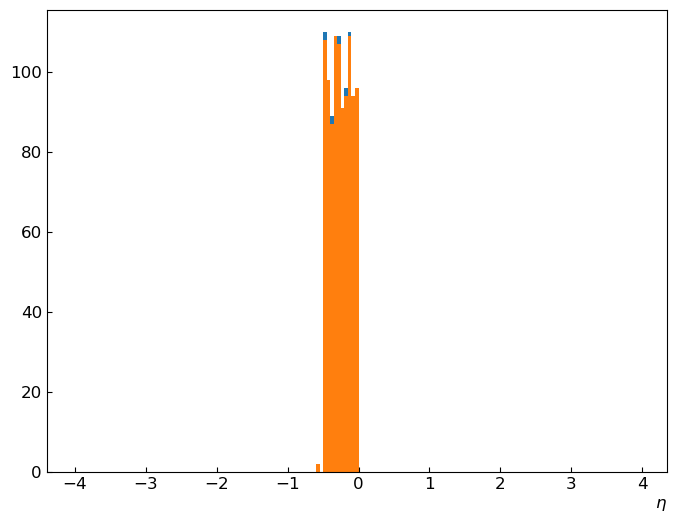

In [3]:
## check eff at 500 MeV: 
# mom_name = "500MeV"
# dir_path = f"EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/{mom_name}/130to177deg/"
# fname    = f"pi+_{mom_name}_130to177deg.0001.eicrecon.tree.edm4eic.root"

dir_path=""
fname=  "/global/cfs/cdirs/m3763/amir/workspace/benchmarks/Test_Curved/Benchmarks/eta_bin_-0.5_to_0.0/out/reconstructed/recon_10GeV.root"

pion_o, pion, params = pre_proc(fname,dir_path)
# plt.scatter(pion_o.theta/deg2rad,pion_o.phi/deg2rad)
eta_bins = np.arange(-4,4,0.05)
plt.figure()
_=plt.hist(pion_o.eta,bins=eta_bins)
_=plt.hist(params.eta,bins=eta_bins)
plt.xlabel("$\eta$")



Text(1, 0, 'DCA$_r$ [mm]')

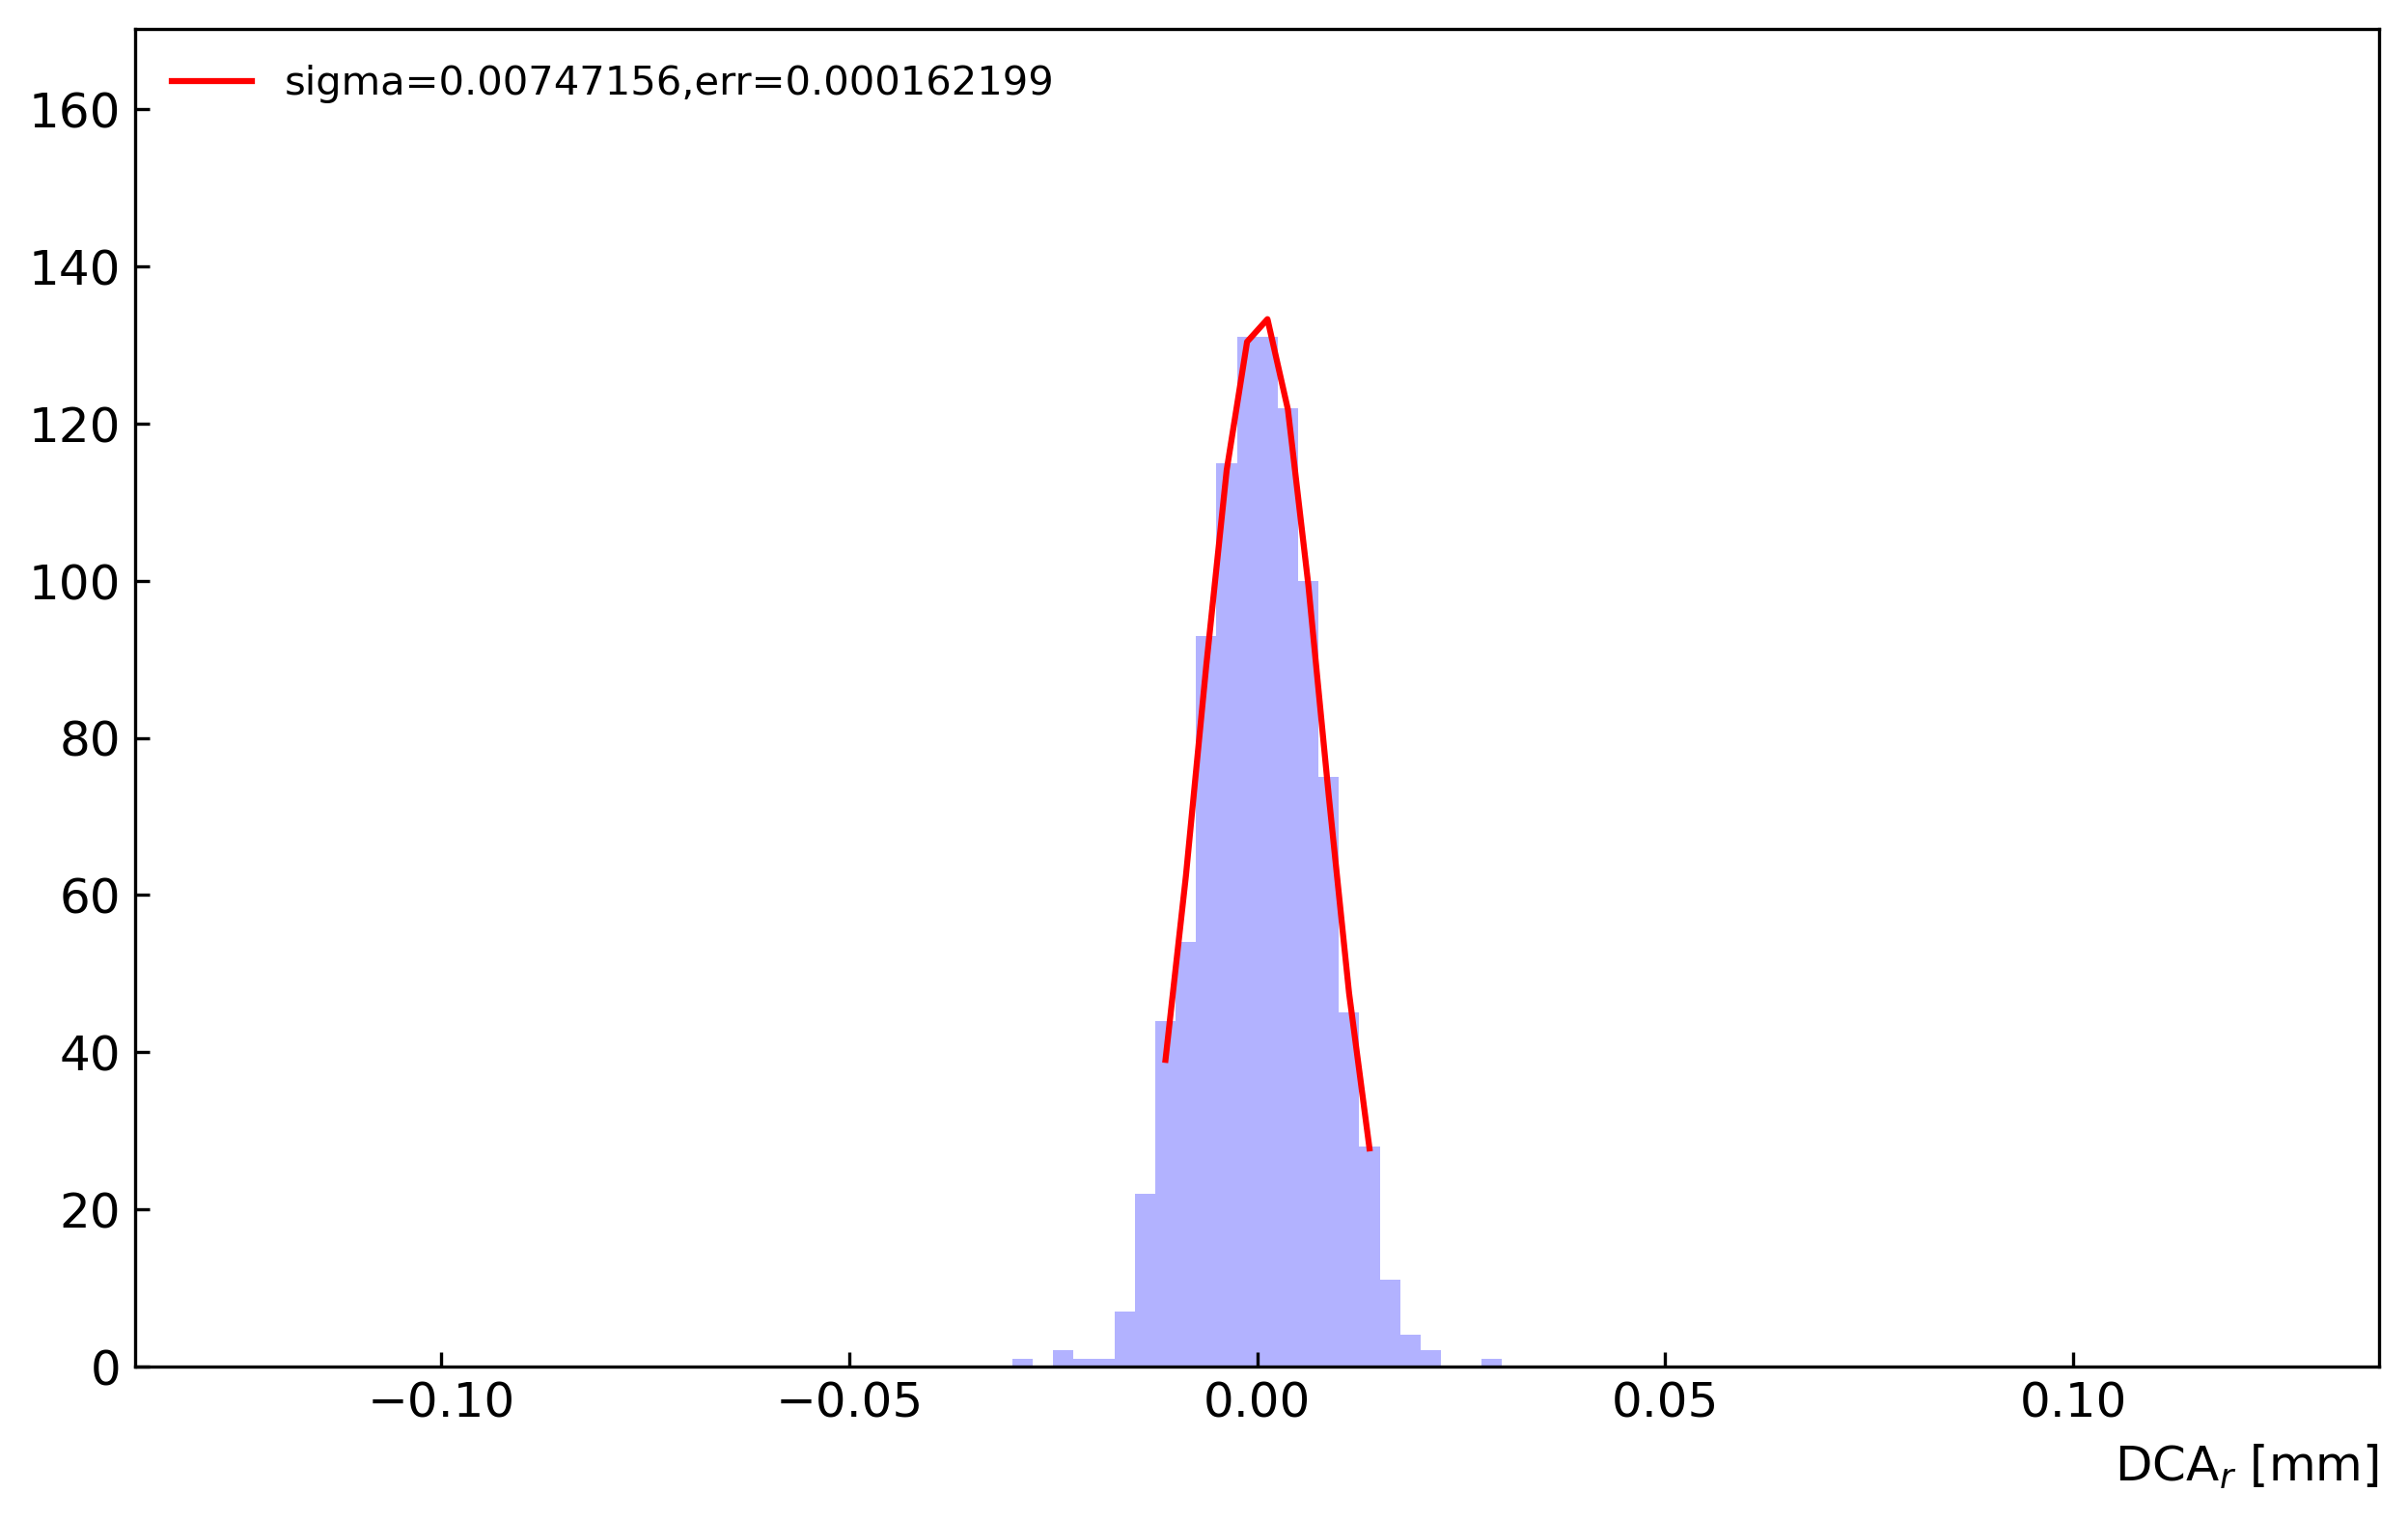

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,6),dpi=300)
obs    = 'loc.a'
rec_th = np.array(params[obs])
sim_th = 0
dth_th = (rec_th - sim_th)
sig_dca,err_dca=hist_gaus(dth_th,ax,np.linspace(-1, 1, 101),klog=0,header=None)
plt.xlabel(r'DCA$_r$ [mm]')#, fontsize=20)

/tmp/ipykernel_1528195/469084983.py:229: RuntimeWarning: invalid value encountered in divide
  track_eff = np.nan_to_num(np.array(rec_eta)/np.array(sim_eta))
/tmp/ipykernel_1528195/469084983.py:234: RuntimeWarning: divide by zero encountered in reciprocal
  track_err = np.nan_to_num(track_eff*(1. - track_eff)*np.reciprocal(np.sqrt(sim_eta)))
/tmp/ipykernel_1528195/469084983.py:234: RuntimeWarning: invalid value encountered in multiply
  track_err = np.nan_to_num(track_eff*(1. - track_eff)*np.reciprocal(np.sqrt(sim_eta)))


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.99038462, 0.99621212,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0006603 , 0.00013409,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([-3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,
         0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8]),
 <Figure size 600x600 with 1 Axes>)

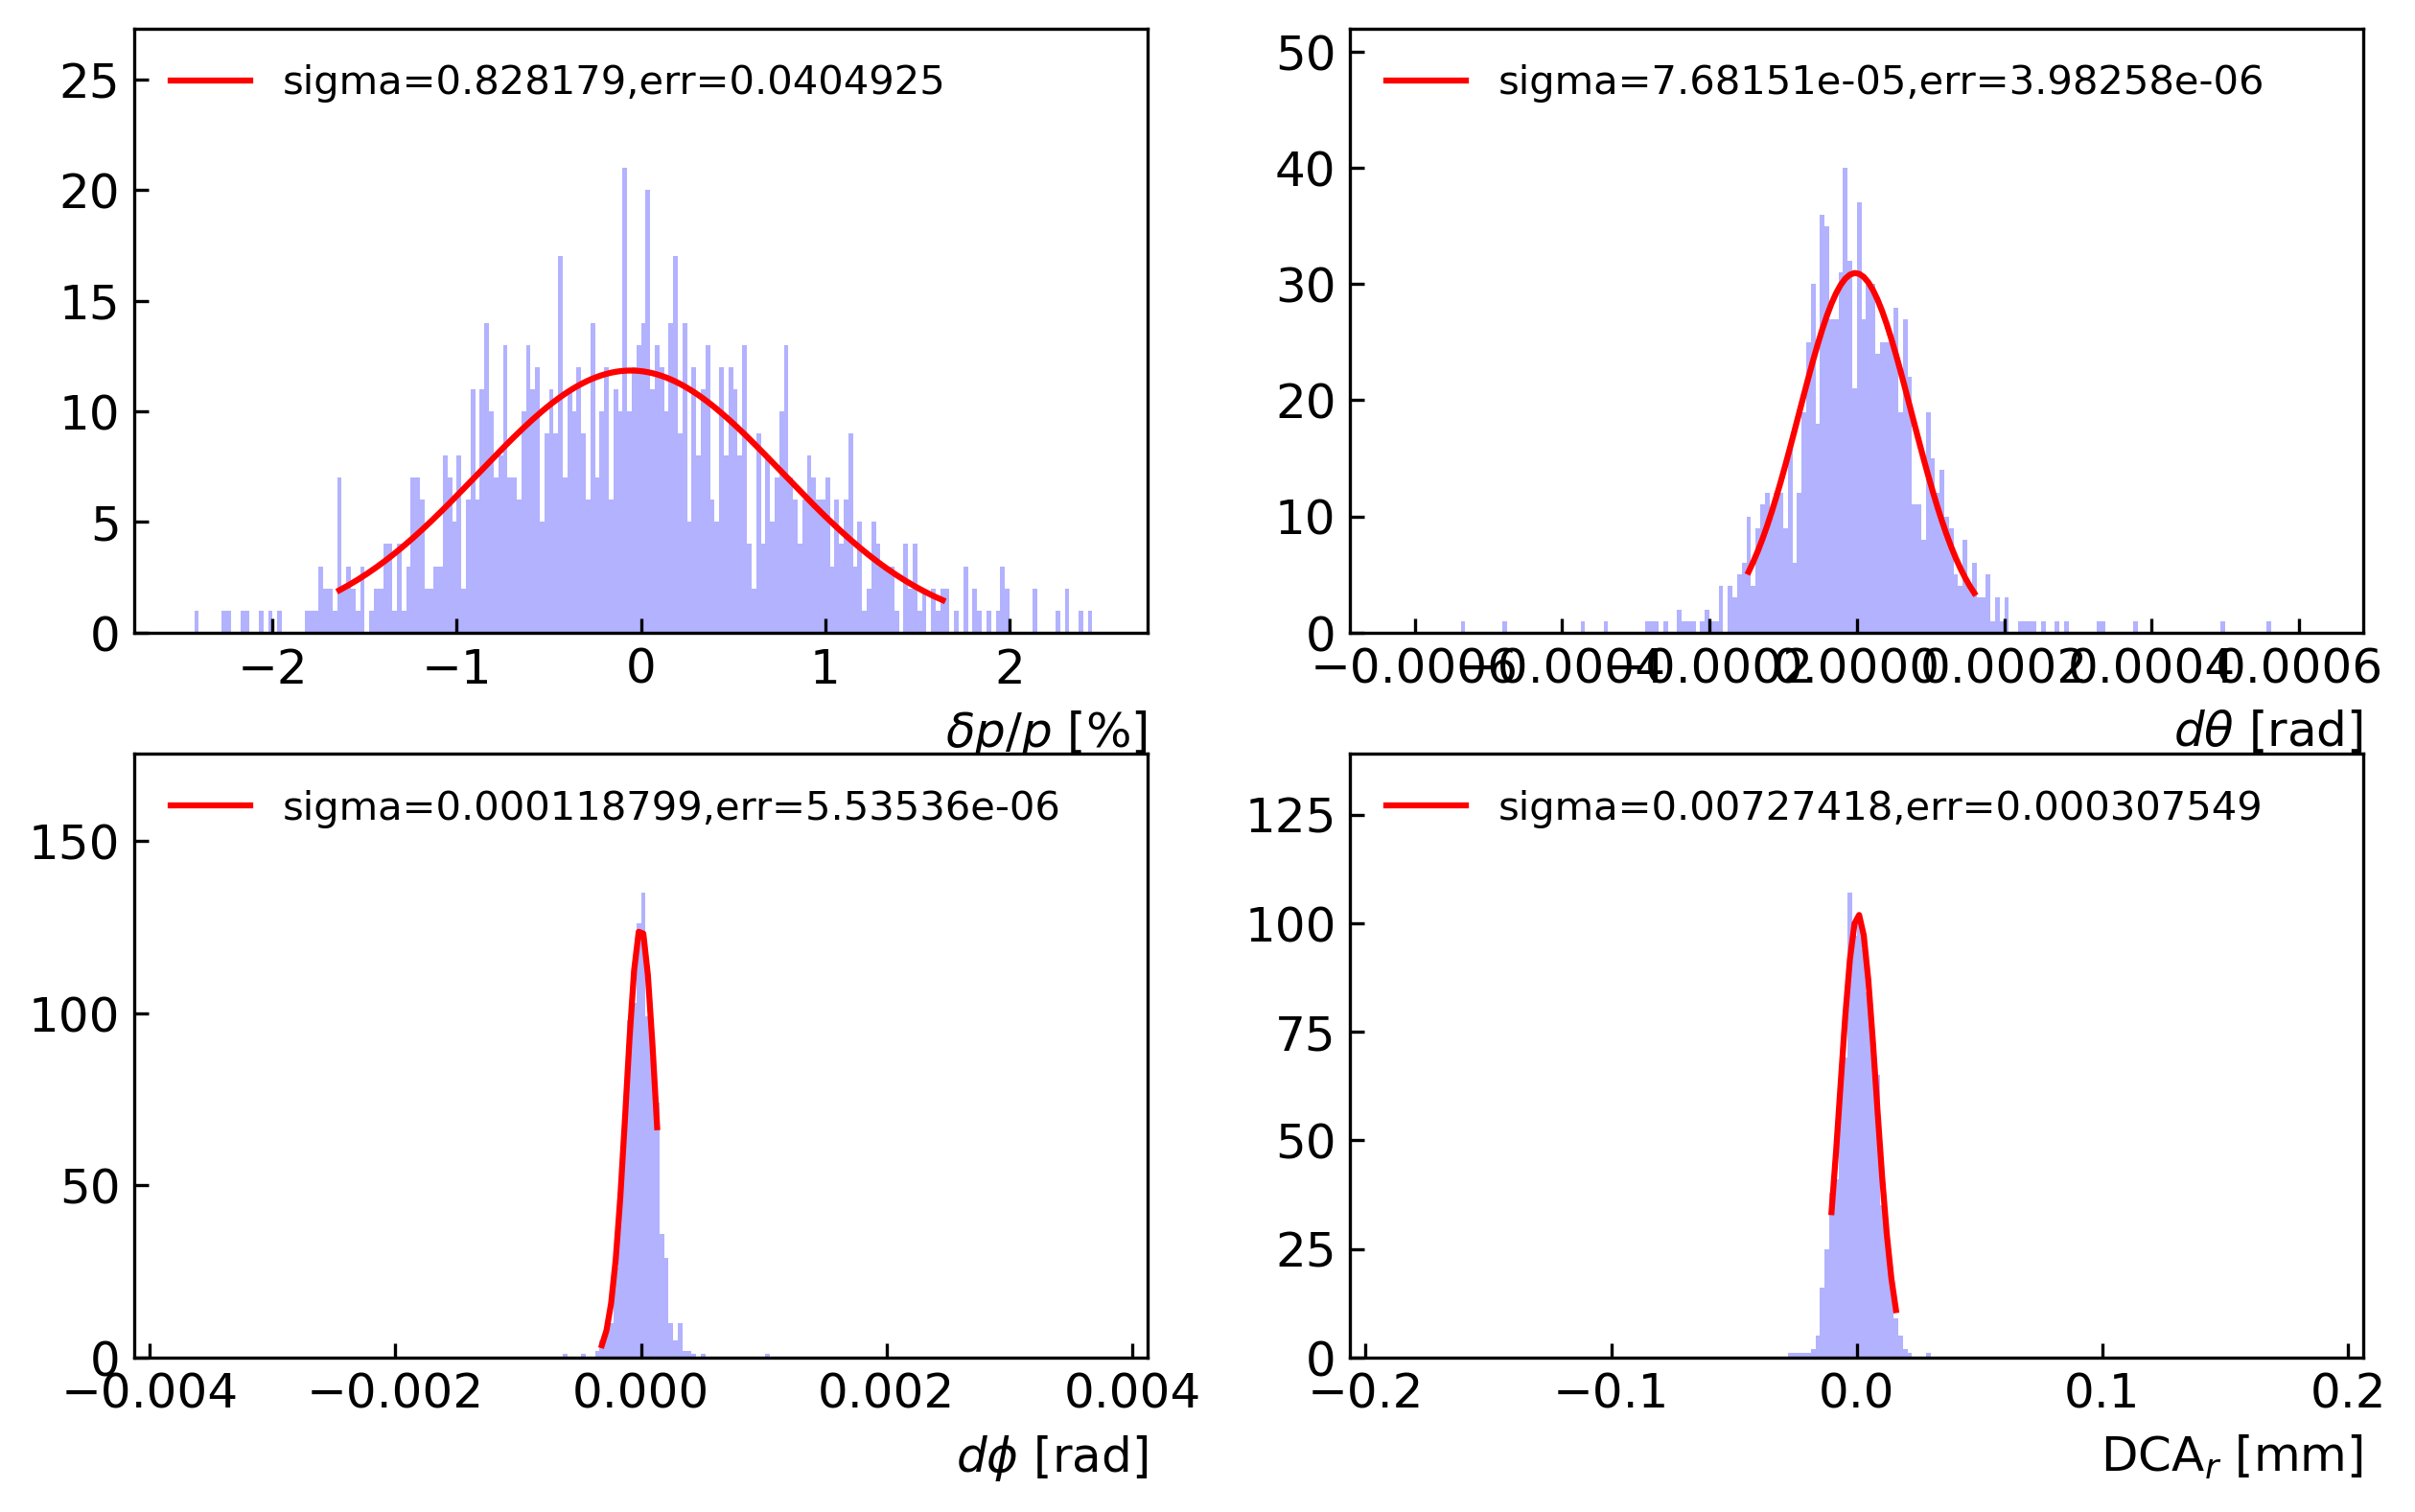

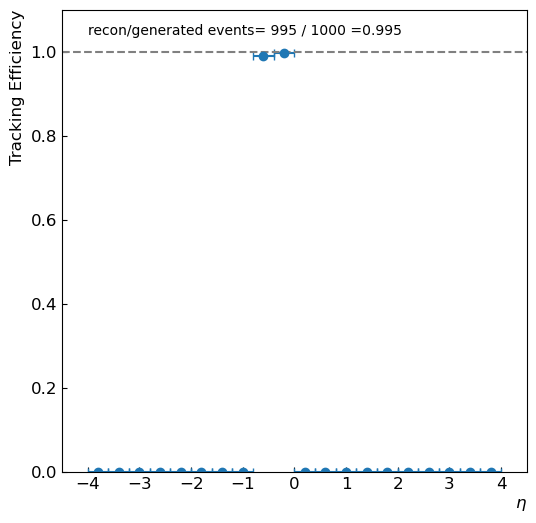

In [5]:
plot_resol(pion,params)
plot_eff(pion_o,pion)


## calculate eff and resol 

### with local file

In [ ]:
performance_plot(fname,dir_path,eff_eta_bins=[], resol_deg_bins=resol_deg_bins, kchain=kchain)


### with official simulation

5GeV 3to50deg will chain 10 files
read_ur: read root://dtn-eic.jlab.org//work/eic2/EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/5GeV/3to50deg/pi+_5GeV_3to50deg.0001.eicrecon.tree.edm4eic.root:events. 20000 events in total
chain  pi+_5GeV_3to50deg.0002.eicrecon.tree.edm4eic.root
read_ur: read root://dtn-eic.jlab.org//work/eic2/EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/5GeV/3to50deg/pi+_5GeV_3to50deg.0002.eicrecon.tree.edm4eic.root:events. 20000 events in total
chain  pi+_5GeV_3to50deg.0003.eicrecon.tree.edm4eic.root
read_ur: read root://dtn-eic.jlab.org//work/eic2/EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/5GeV/3to50deg/pi+_5GeV_3to50deg.0003.eicrecon.tree.edm4eic.root:events. 20000 events in total
chain  pi+_5GeV_3to50deg.0004.eicrecon.tree.edm4eic.root
read_ur: read root://dtn-eic.jlab.org//work/eic2/EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/5GeV/3to50deg/pi+_5GeV_3to50deg.0004.eicrecon.tree.edm4eic.root:events. 20000 events in total
chain  pi+_5GeV_3to50deg.0005.eicrecon.tree

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m3763/amir/workspace/benchmarks/lib/output/resol_pi+_5GeV_3to50deg.0001.eicrecon.tree.edm4eic_theta_3_10.png'

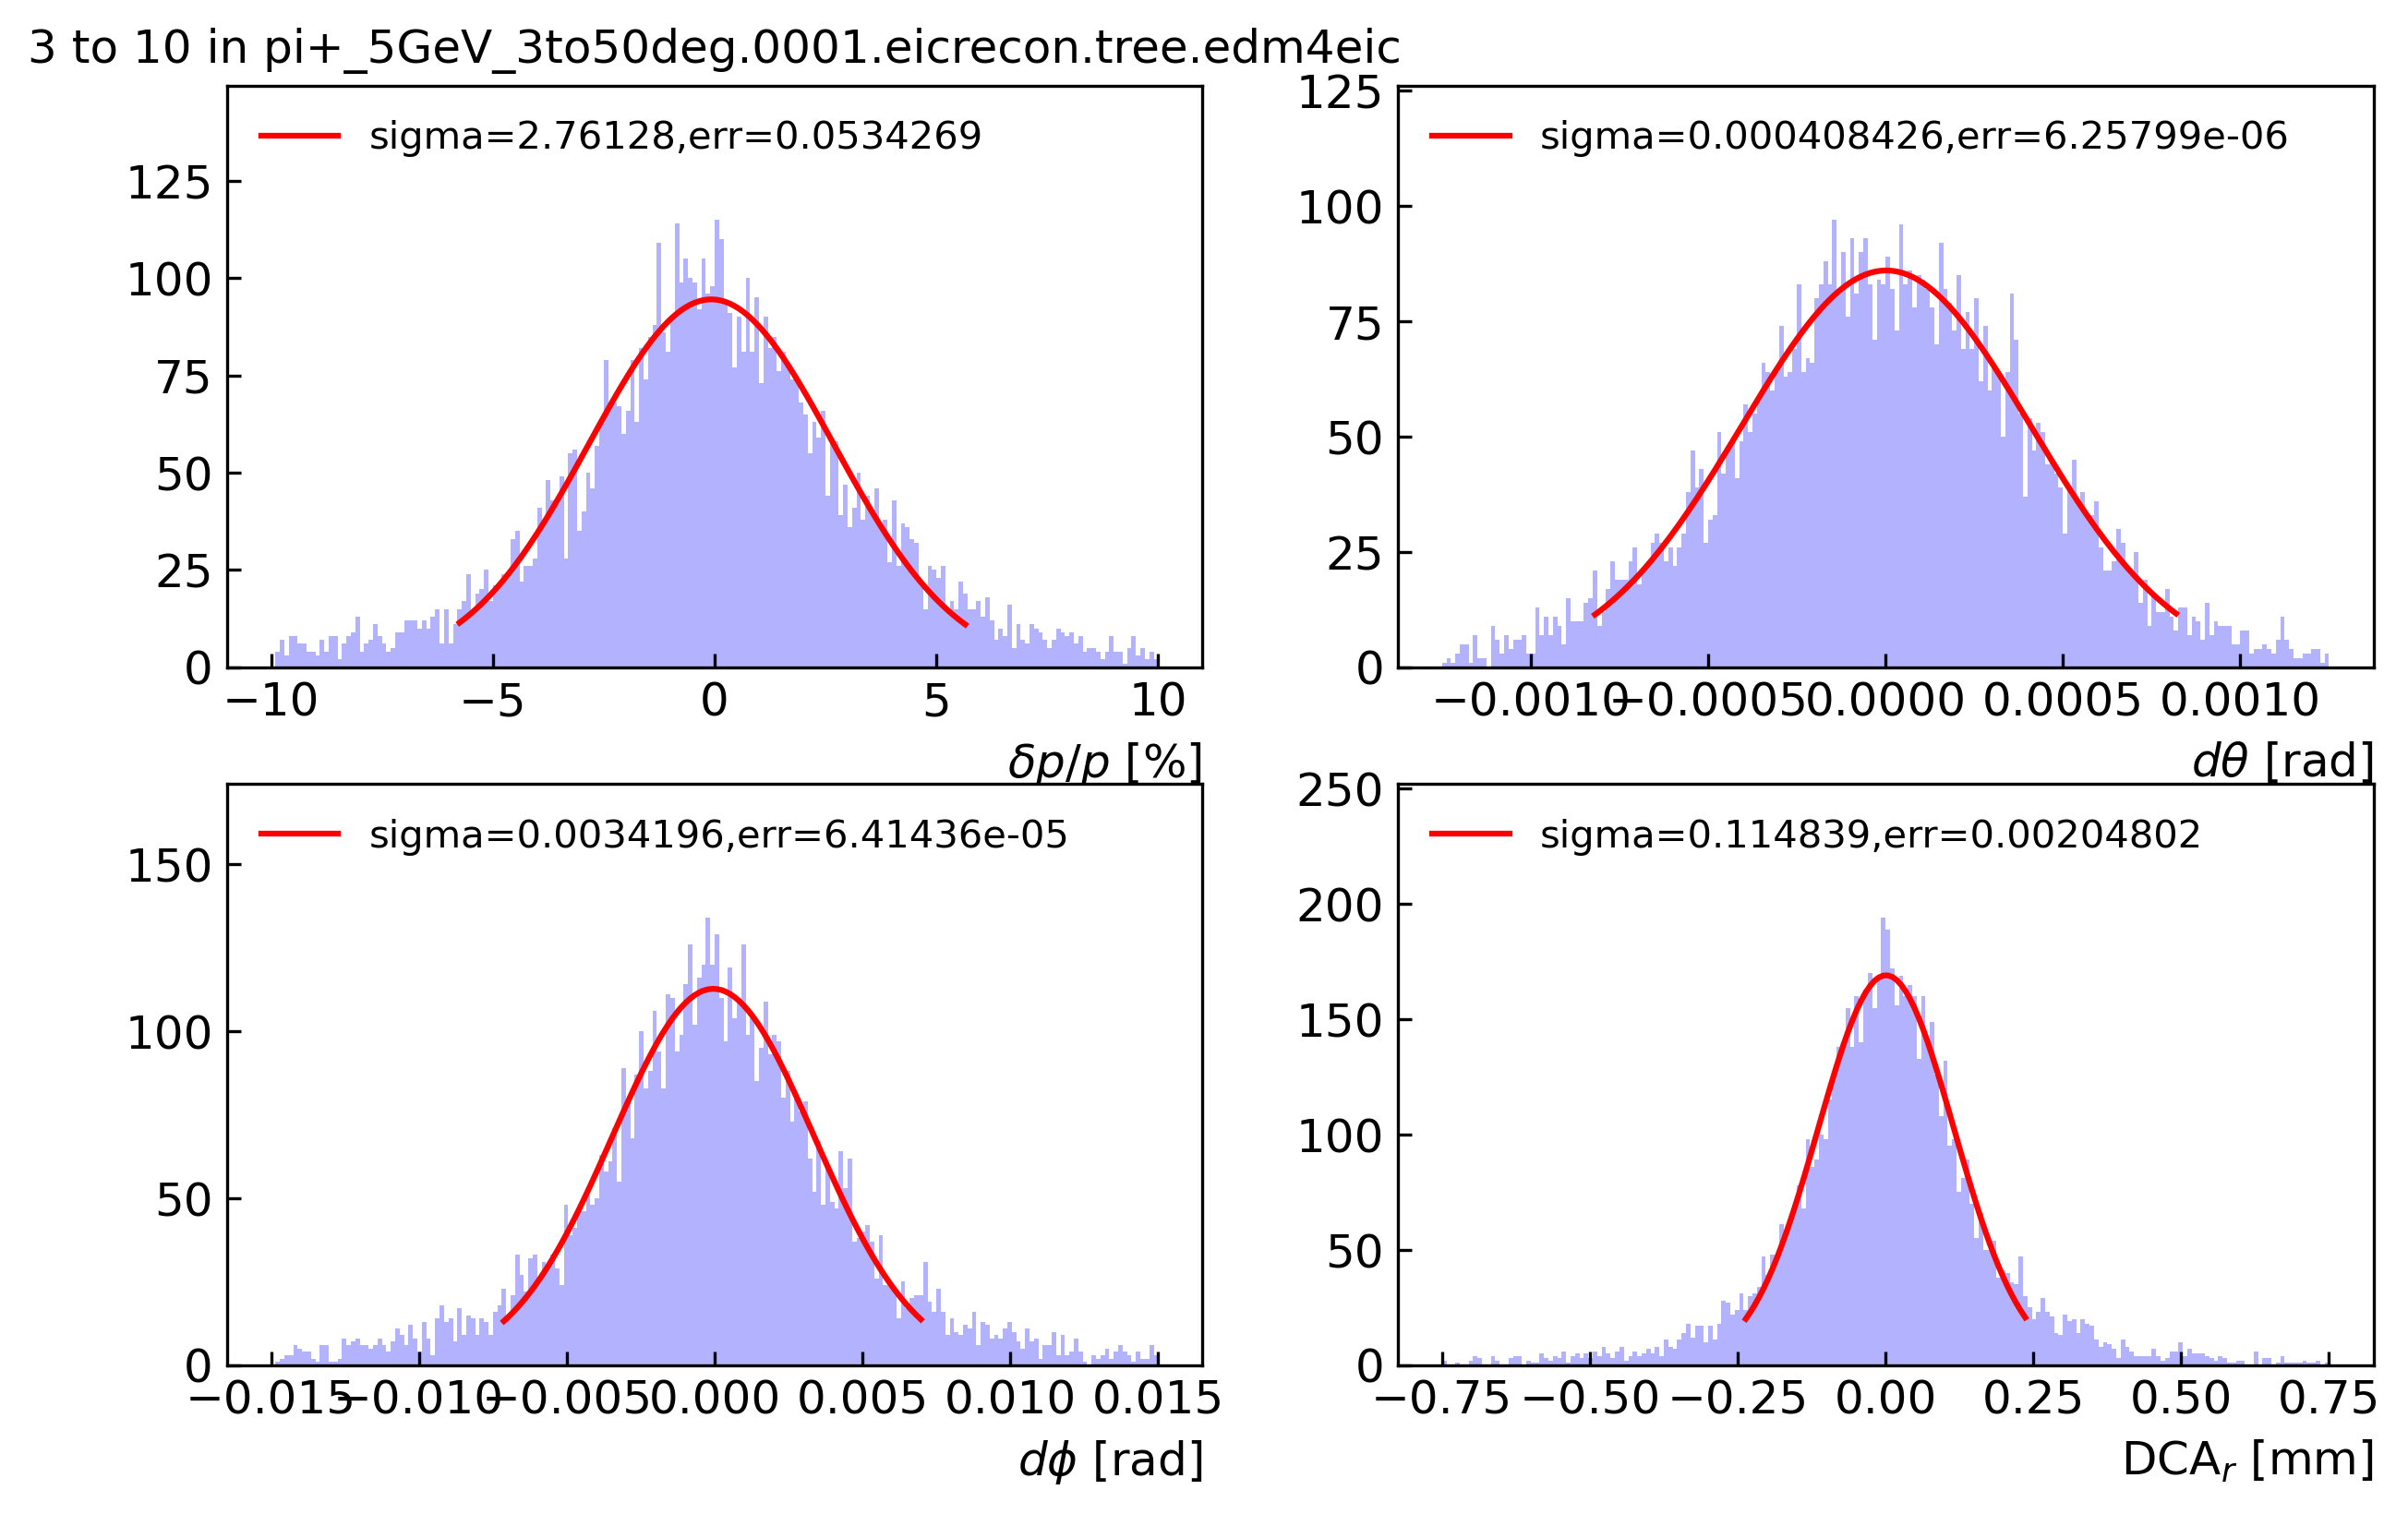

In [6]:
mom_list=['5GeV'] ## omit 100 and 200 MeV
# deg_list=['3to50deg','130to177deg']

# mom_list=['500MeV', '1GeV', '2GeV', '5GeV', '10GeV', '20GeV'] ## omit 100 and 200 MeV
deg_list=['3to50deg']#, '45to135deg','130to177deg']

eff_eta_bins   = np.linspace(-4,4,41)
resol_eta_bins = np.array([-3.5,-2.5,-1,1,2.5,3.5])
resol_deg_bins = np.array([3,10,40,140,170,177])

for mom_name in mom_list:
    for deg_name in deg_list:
        dir_path = f"EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/{mom_name}/{deg_name}/"
        fname    = f"pi+_{mom_name}_{deg_name}.0001.eicrecon.tree.edm4eic.root"
        # args_list.append((fname,dir_path))
        kchain = 0
        if deg_name=="3to50deg" or deg_name=="130to177deg":
            # if mom_name=="10GeV" or mom_name=="20GeV":
            kchain = 10
            print(mom_name, deg_name,f"will chain {kchain} files")
        performance_plot(fname,dir_path,eff_eta_bins=[], resol_deg_bins=resol_deg_bins, kchain=kchain)
        # break
    # break

# from concurrent.futures import ThreadPoolExecutor
# import threading
# # Create a lock object
# write_lock = threading.Lock()
# args_list=[]
# for mom_name in mom_list:
#     for deg_name in deg_list:
#         dir_path = f"EPIC/RECO/24.07.0/epic_craterlake/SINGLE/pi+/{mom_name}/{deg_name}/"
#         fname    = f"pi+_{mom_name}_{deg_name}.0001.eicrecon.tree.edm4eic.root"
#         args_list.append((fname,dir_path))
#     break
# def wrapper(args):
#     return performance_plot(*args)
# # List of arguments
# with ThreadPoolExecutor(max_workers=3) as executor:
#     executor.map(wrapper, args_list)

## plot results from txt file

### plot eff 

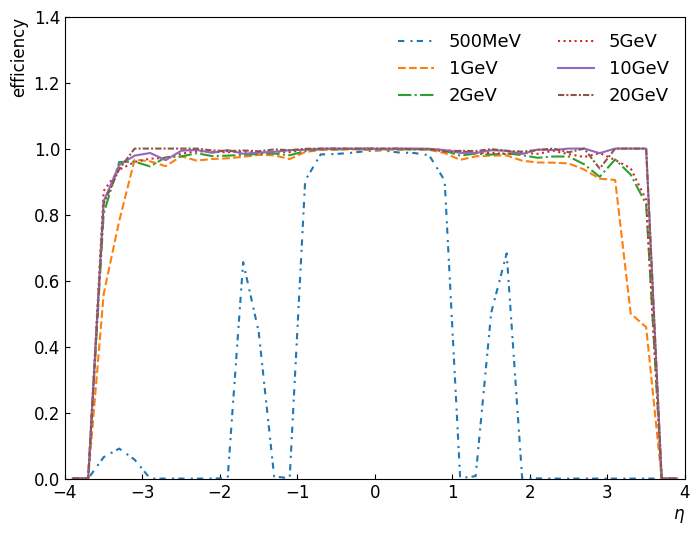

In [ ]:
## plot eff v.s. mom
df= pd.read_csv('eff_out_slices.txt',header=None,sep=";")
df.columns=["theta_range","mom_range","eff","err","eta_bins"]

# np.seterr(divide='ignore', invalid='ignore')
eta_bins=np.array(ast.literal_eval(df.eta_bins[0]))
# x = (eta_bins[:-1]+eta_bins[1:])/2
# for mom in df["mom_range"].unique():
line_styles = [ (0, (3, 3, 1, 2)),  '--', '-.', ':','-',(0, (3, 1, 1, 1))]
for ii,mom in enumerate(['500MeV', '1GeV', '2GeV', '5GeV', '10GeV', '20GeV']):
    cond = df.mom_range==mom
    dft  = df[cond]
    ys   = 0
    cnt  = 0
    for i in dft.index:
        row   = df.iloc[i]
        yy    = np.array(ast.literal_eval(row.eff))
        ee    = np.array(ast.literal_eval(row.err))
        cnt   += (yy != 0).astype(int)
        ys    += unp.uarray(yy,ee)
    cnt[cnt==0]=1 # set cnt to 1 when there's no non-zero values in that bin to avoid division error 0/0
    ys   = np.divide(ys,cnt)
    plt.plot(eta_bins, unp.nominal_values(ys),ls=line_styles[ii],label=f"{mom}")
    # plt.errorbar(eta_bins,unp.nominal_values(ys),yerr=unp.std_devs(ys),ls="-",marker=".",label=f"{mom}")
    # print(mom,y)
# a=df[1].values[0]
# import ast
plt.legend(frameon=0, loc="upper right",ncol=2, fontsize=13)
plt.ylim(0.,1.4)
plt.xlim(-4,4)
plt.xlabel("$\eta$")
plt.ylabel("efficiency")
plt.savefig("../output/tracking_eff_no_offset.pdf")

### plot resol

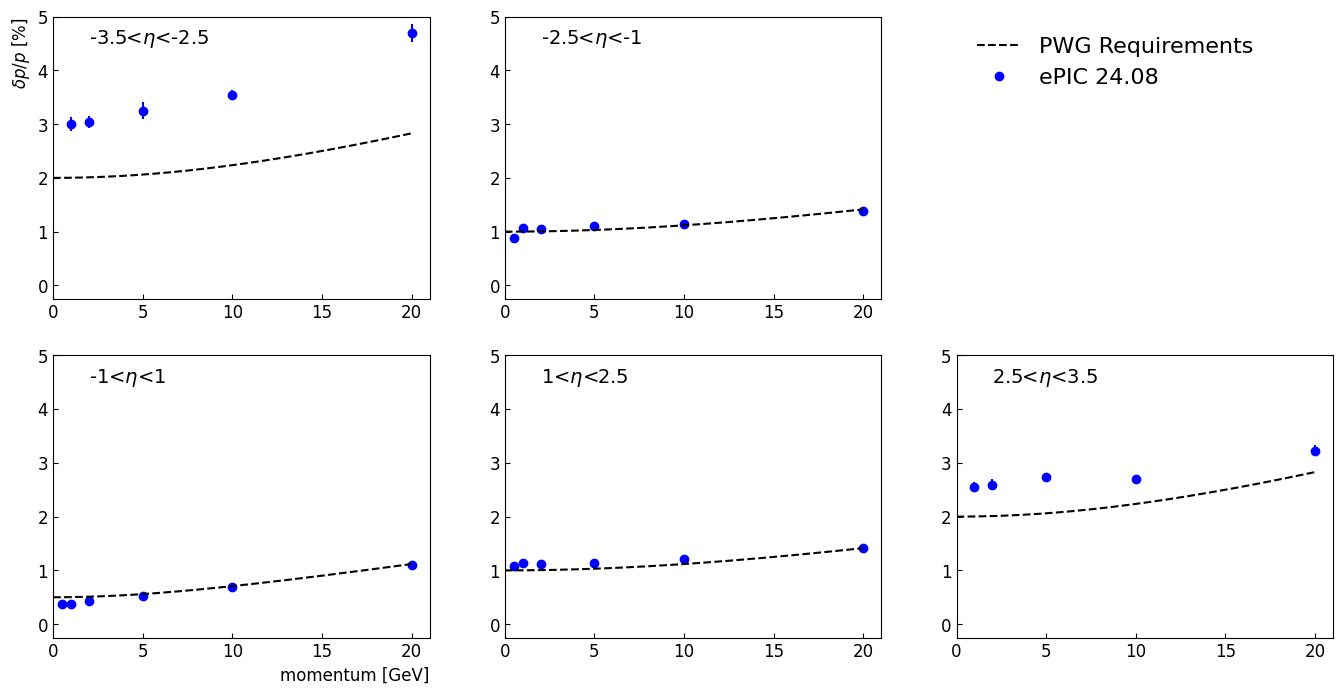

In [ ]:
## campaign rootfiles
pwg = pd.read_csv('pwg_requirements.txt',sep="\t",skiprows=1)

df         = pd.read_csv('resol_out_slices.txt',header=None,sep=" ")
df.columns = ["tag","theta_lo","theta_hi","sig_dp", "err_dp", "sig_th", "err_th", "sig_ph", "err_ph", "sig_dca", "err_dca"]
df = df.replace(-1,0)
# pi+_500MeV_3to50deg.0001.eicrecon.tree.edm4eic
df["deg_range"]=[ dd.split('.')[0].split('_')[-1]  for dd in df.tag]
df["mom_range"]=[ dd.split('.')[0].split('_')[1]  for dd in df.tag]
def energy_key(energy):
    # Extract the numerical part and the unit
    value, unit = float(energy[:-3]), energy[-3:]
    # Convert to MeV if necessary
    if unit == 'MeV':
        value /= 1000.0  # Convert MeV to GeV
    return value
df["mom"]=[energy_key(ee) for ee in df.mom_range]
eta_sample = [(-4,-3),(-2,-1),(0,1),(1,2),(3,4)]

# [  3  10  40 140 170 177]
deg_sample = ['130to177deg','130to177deg','45to135deg','3to50deg','3to50deg' ]
deg_cut    = [177,     170,  140,  40,     10,  3]
eta_lo_pwg = [-3.5,   -2.5,   -1,   1,    2.5  ]  
eta_hi_pwg = [-2.5,   -1,   1,    2.5,    3.5  ]  
# dp_hi      = [5,5,5,5,5]

xline      = np.arange(0,20,0.001)

varname  = "dp"
y_hi     = 5
yname    = r"$\delta p/p$ [%]"
xname    = "momentum [GeV]"
x_hi      = [20,20,20,20,20]

# varname  =  "dca"
# y_hi     = 1
# yname    = "DCA$_r$ [mm]"
# xname    = "pT [GeV]"
# x_hi     = [2,5,10,5,2]

def pwg_curve(x, a, b,varname):
    if varname=="dca":
        return np.sqrt((a/1000.0 / x)**2 + (b/1000.0)**2)
    elif varname=="dp":
        return np.sqrt((a * x)**2 + b**2)
    else: 
        return 0

fig,axs=plt.subplots(2,3,figsize=(16,9), dpi=100,sharex=0)
axs = axs.flat
ii=0
for ii, e_lo in enumerate(eta_lo_pwg):
    ax   = axs[ii]
    if ii>1:
        ax   = axs[ii+1]
        
    d_lo = deg_cut[ii]
    cond1 = df.theta_hi==d_lo
    cond2 = df.deg_range==deg_sample[ii]
    # print(d_lo,deg_sample[ii])
    dft  = df[(cond1&cond2)]
    if varname=="dp":
        xdata = dft.mom
    elif varname=="dca":
        xdata = dft.mom*np.sin((deg_cut[ii]+deg_cut[ii+1])/2*deg2rad)
    ax.errorbar(xdata,dft["sig_"+varname],yerr=dft["err_"+varname],color="b",ls="none",marker="o")#,label=f"{e_lo} to {eta_hi_pwg[ii]}")

    cond = pwg.eta_lo == e_lo
    p1 = pwg[varname+"_par1"].values[cond][0]
    p2 = pwg[varname+"_par2"].values[cond][0]
    # print(p1,p2)
    y_pwg = pwg_curve(xline,p1,p2,varname)
    ax.plot(xline, y_pwg, 'k--',zorder=10)
    ax.set_ylim(-y_hi*0.05,y_hi)
    ax.set_xlim(0,x_hi[ii]*1.05)
    ax.text(x_hi[ii]*0.1,y_hi*0.9, f"{e_lo}<$\eta$<{eta_hi_pwg[ii]}",fontsize=14)

ax = axs[2]
ax.axis('off')
ax.plot(xline, y_pwg-100000, "k--",label="PWG Requirements")
ax.errorbar(xline,y_pwg-100000,ls="none",marker="o",color="blue",label="ePIC 24.08")#,label=f"{e_lo} to {eta_hi_pwg[ii]}")
ax.set_ylim(0,1)
ax.legend(frameon=0,loc="upper left",fontsize=16)

axs[3].set_xlabel(xname)
axs[0].set_ylabel(yname)

plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.3)

plt.savefig(f"../output/tracking_single_resol_{varname}_eta.pdf")

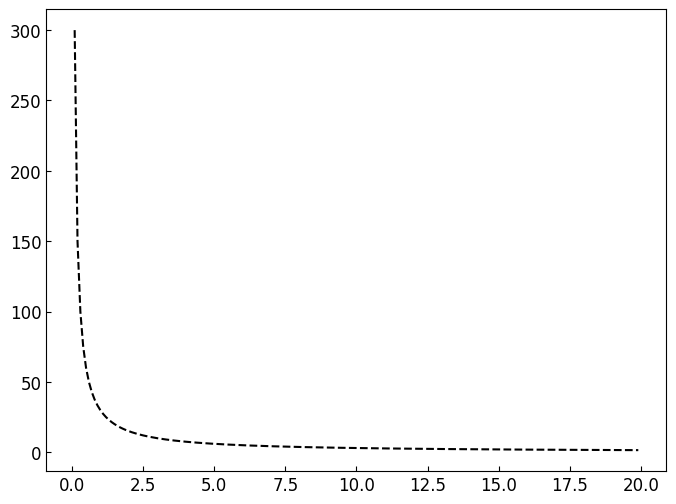

In [ ]:
plt.plot(xline, y_pwg, 'k--',zorder=10)


In [ ]:

## local rootfiles with eta bin of 1
fig,axs=plt.subplots(2,3,figsize=(16,9), dpi=100)
df         = pd.read_csv('resol_out_whole.txt',header=None,sep=" ")
df.columns = ["tag","sig_dp", "err_dp", "sig_th", "err_th", "sig_ph", "err_ph", "sig_dca", "err_dca"]
df = df.replace(-1,0)

df["mom"]=[float(tt.split("GeV")[0].split("_")[-1]) for tt in df.tag]
df["eta_lo"]=[float(tt.split("eta")[1].split("_")[0]) for tt in df.tag]
df["eta_hi"]=[float(tt.split("eta")[1].split("_")[1]) for tt in df.tag]

eta_sample = [(-4,-3),(-2,-1),(0,1),(1,2),(3,4)]
eta_lo_pwg = [-3.5,   -2.5,   -1,   1,    2.5  ]  
eta_hi_pwg = [-2.5,   -1,   1,    2.5,    3.5  ]  
dp_hi      = [15,5,5,5,15]
xline      = np.arange(0,20,0.1)
varname  = "dp"
for ii, e_lo in enumerate(eta_lo_pwg):
    ax    = axs.flat[ii+1]
    d_lo, d_hi = eta_sample[ii]
    cond1 = df.eta_lo==d_lo
    cond2 = df.eta_hi==d_hi
    dft  = df[(cond1&cond2)]
    ax.errorbar(dft.mom,dft["sig_"+varname],yerr=dft["err_"+varname],ls="none",marker="x",label=f"{d_lo} to {d_hi}")

    cond = pwg.eta_lo == e_lo
    p1 = pwg[varname+"_par1"].values[cond][0]
    p2 = pwg[varname+"_par2"].values[cond][0]
    print(p1,p2)
    y_pwg = pwg_curve(xline,p1,p2,varname)
    ax.plot(xline, y_pwg, color="b",ls='--', label="PWG Requirements",zorder=10)
    ax.set_ylim(0,dp_hi[ii])
    ax.set_title(f"{d_lo}, {d_hi}")
plt.legend()
# plt.ylim(0,2)